## Collecting some raw images

In [3]:
from google.colab import files
import os, zipfile, shutil

os.makedirs("dataset/raw_images", exist_ok=True)

uploaded = files.upload()  # upload images OR a .zip folder

for name in uploaded.keys():
    if name.endswith(".zip"):
        # Unzip folder into raw_images
        with zipfile.ZipFile(name, 'r') as zip_ref:
            for file_info in zip_ref.infolist():
                if not file_info.is_dir():
                    target_path = os.path.join("dataset/raw_images", os.path.basename(file_info.filename))
                    if target_path.startswith("dataset/raw_images/"):
                        zip_ref.extract(file_info, "dataset/raw_images")
        print(f"Extracted {name} into dataset/raw_images")
    else:
        # If user uploaded individual images
        os.rename(name, f"dataset/raw_images/{name}")

# Flatten nested folders (move all images into raw_images/) and remove non-image files/folders
raw_dir = "dataset/raw_images"
valid_exts = (".jpg", ".jpeg", ".png")

for root, dirs, files in os.walk(raw_dir):
    for fname in files:
        src = os.path.join(root, fname)
        dst = os.path.join(raw_dir, fname)
        if fname.lower().endswith(valid_exts):
            if src != dst:  # move only if needed
                shutil.move(src, dst)
        else:
            os.remove(src)  # remove non-images

# Remove empty subfolders
for root, dirs, files in os.walk(raw_dir, topdown=False):
    for d in dirs:
        folder_path = os.path.join(root, d)
        if not os.listdir(folder_path):
            os.rmdir(folder_path)

print("Raw images sample:", os.listdir("dataset/raw_images")[:5])


Saving dataset.zip to dataset (1).zip
Extracted dataset (1).zip into dataset/raw_images
Raw images sample: ['0003178.jpg', '141.png', 'Phone_indoor_01 (1).jpg', 'download (3).jpg', '030_60acb78e.jpg']


## Auto generated mask images with rembg

In [4]:
!pip install rembg pillow onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.4 MB/s eta 0:00:00


In [5]:
from rembg import remove
from PIL import Image

os.makedirs("dataset/masks", exist_ok=True)

# Ensure valid_exts is defined
valid_exts = (".jpg", ".jpeg", ".png")

for fname in os.listdir("dataset/raw_images"):
    fpath = os.path.join("dataset/raw_images", fname)

    if os.path.isdir(fpath) or not fname.lower().endswith(valid_exts):
        continue

    try:
        img = Image.open(fpath).convert("RGB")
        cut = remove(img)   # RGBA PIL image with alpha mask
        alpha = cut.getchannel("A")  # Extract mask

        mask_name = os.path.splitext(fname)[0] + ".png"
        alpha.save(os.path.join("dataset/masks", mask_name))
    except Exception as e:
        print(f"Error processing {fname}: {e}")


print("Masks saved:", os.listdir("dataset/masks")[:5])

100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 30.0GB/s]


Masks saved: ['0000631.png', 'Selfie_5.png', 'ID_1 (1).png', '004_94f26ed9.png', '0003957.png']


## Data Augmentation

Offline Augmentation (before training)

This is what we did earlier with Albumentations to save extra images into
dataset/aug_images/ and dataset/aug_masks/.

Purpose: increase dataset size permanently before training.

In [6]:
!pip install albumentations opencv-python

In [7]:
import albumentations as A
import cv2
import os

aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.Resize(300, 300),
    A.RandomCrop(256, 256, p=0.5)
])

os.makedirs("dataset/aug_images", exist_ok=True)
os.makedirs("dataset/aug_masks", exist_ok=True)

valid_exts = (".jpg", ".jpeg", ".png")

for fname in os.listdir("dataset/raw_images"):
    fpath_img = os.path.join("dataset/raw_images", fname)
    fpath_mask = os.path.join("dataset/masks", os.path.splitext(fname)[0] + ".png")

    if os.path.isdir(fpath_img) or not fname.lower().endswith(valid_exts):
        continue

    img = cv2.imread(fpath_img)
    mask = cv2.imread(fpath_mask, 0)

    if img is None or mask is None:
        print(f"Skipping {fname} (img or mask not found)")
        continue

    base_name = os.path.splitext(fname)[0]

    for i in range(3):  # 3 augmentations per image
        augmented = aug(image=img, mask=mask)
        img_aug, mask_aug = augmented["image"], augmented["mask"]

        img_name = f"{base_name}_{i}.jpg"
        mask_name = f"{base_name}_{i}.png"

        cv2.imwrite(f"dataset/aug_images/{img_name}", img_aug)
        cv2.imwrite(f"dataset/aug_masks/{mask_name}", mask_aug)

print("Augmentation completed!")



Augmentation completed!


In [8]:
# count images
import os

base_dir = "dataset"
folders = ["raw_images", "masks", "aug_images", "aug_masks"]

for folder in folders:
    path = os.path.join(base_dir, folder)
    num_files = len(os.listdir(path))
    print(f"{folder}: {num_files} files")


raw_images: 106 files
masks: 106 files
aug_images: 318 files
aug_masks: 318 files


In [9]:
import os
# Better to filter only valid image files:
base_dir = "dataset"
folders = ["raw_images", "masks", "aug_images", "aug_masks"]

valid_exts = (".jpg", ".jpeg", ".png")

for folder in folders:
    path = os.path.join(base_dir, folder)
    if not os.path.exists(path):
        print(f"{folder}: folder not found")
        continue
    num_files = len([f for f in os.listdir(path) if f.lower().endswith(valid_exts)])
    print(f"{folder}: {num_files} image files")


raw_images: 106 image files
masks: 106 image files
aug_images: 318 image files
aug_masks: 318 image files


In [10]:
# Optional: also check pairs match

# Especially important for segmentation — we want each image to have a mask with the same base name.

raw_imgs = set(os.path.splitext(f)[0] for f in os.listdir("dataset/raw_images") if f.endswith(valid_exts))
masks = set(os.path.splitext(f)[0] for f in os.listdir("dataset/masks") if f.endswith(".png"))

missing_masks = raw_imgs - masks
missing_imgs = masks - raw_imgs

print("Missing masks:", missing_masks)
print("Missing raw images:", missing_imgs)


Missing masks: set()
Missing raw images: set()


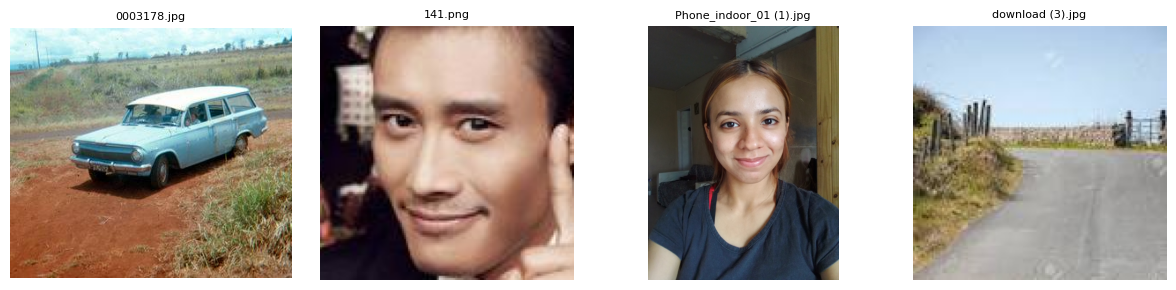

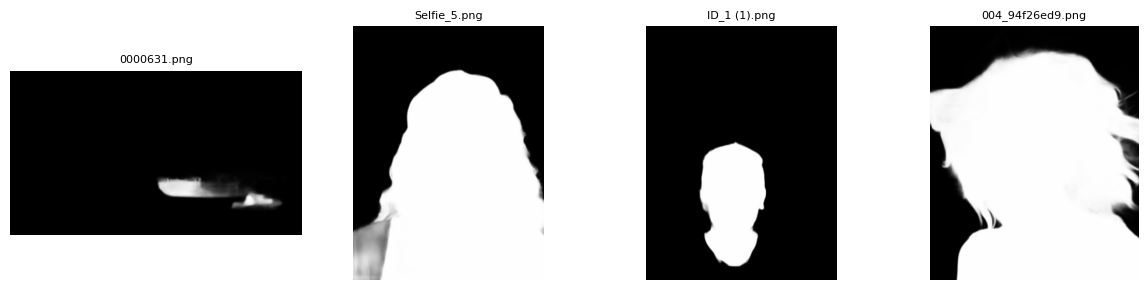

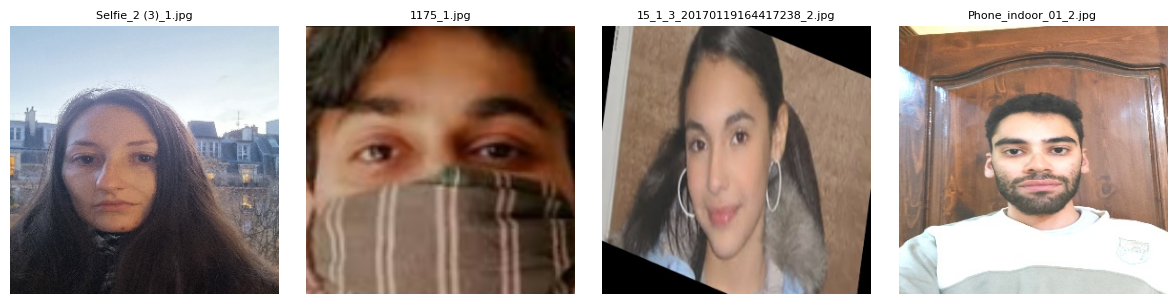

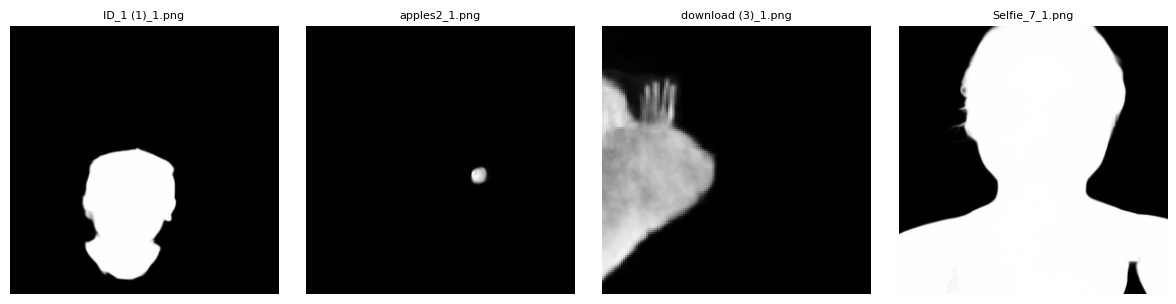

In [12]:
# preview images in each folder
import matplotlib.pyplot as plt
import cv2
import os


def show_images_from_folder(folder, n=4):
    files = [f for f in os.listdir(folder) if not f.startswith('.')] # exclude hidden files
    files = files[:n]
    plt.figure(figsize=(12, 3))

    for i, fname in enumerate(files):
        img_path = os.path.join(folder, fname)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Could not read image: {img_path}")
            continue

        if len(img.shape) == 2:  # grayscale mask
            plt.subplot(1, n, i+1)
            plt.imshow(img, cmap="gray")
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, n, i+1)
            plt.imshow(img)

        plt.title(fname, fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_images_from_folder("dataset/raw_images")
show_images_from_folder("dataset/masks")
show_images_from_folder("dataset/aug_images")
show_images_from_folder("dataset/aug_masks")

## Train-Test Split
### train/val (80/20)

In [13]:
import os
import random
import shutil

# Paths
base = "dataset"
img_dirs = [f"{base}/raw_images", f"{base}/aug_images"]
mask_dirs = [f"{base}/masks", f"{base}/aug_masks"]

# Collect all image-mask pairs
all_images = []
for img_dir, mask_dir in zip(img_dirs, mask_dirs):
    for fname in os.listdir(img_dir):
        img_path = os.path.join(img_dir, fname)
        mask_path = os.path.join(mask_dir, os.path.splitext(fname)[0] + ".png")
        if os.path.exists(mask_path):
            all_images.append((img_path, mask_path))

print(f"Total pairs found: {len(all_images)}")

# Shuffle
random.shuffle(all_images)

# Train/Val split (80/20)
split_idx = int(0.8 * len(all_images))
train_pairs = all_images[:split_idx]
val_pairs = all_images[split_idx:]

# Create folders
for split in ["train", "val"]:
    os.makedirs(f"{base}/{split}/images", exist_ok=True)
    os.makedirs(f"{base}/{split}/masks", exist_ok=True)

# Copy files
def copy_pairs(pairs, split):
    for img_path, mask_path in pairs:
        img_name = os.path.basename(img_path)
        mask_name = os.path.basename(mask_path)
        shutil.copy(img_path, f"{base}/{split}/images/{img_name}")
        shutil.copy(mask_path, f"{base}/{split}/masks/{mask_name}")

copy_pairs(train_pairs, "train")
copy_pairs(val_pairs, "val")

print(f"Train samples: {len(train_pairs)}, Val samples: {len(val_pairs)}")


Total pairs found: 424
Train samples: 339, Val samples: 85


## Training (segmentaion) predicts --> masks

Training the Segmentation Model

We want an AI model that can predict masks (what’s person vs background).

We chose UNet with ResNet34 backbone → powerful but not too heavy.

Trained it on our dataset using Colab GPU.

Used Dice Loss (measures mask similarity).

Measured IoU (Intersection over Union) as accuracy metric.

Training loop:

Model sees photo → predicts mask → compares with true mask → learns.

Validation loop:

Model tested on unseen photos → measures IoU.

👉 Result: A trained UNet model (.pth file) that can segment people from background.

In [14]:
!pip install segmentation-models-pytorch==0.3.3 torchmetrics albumentations opencv-python matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 71.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=ff0a269af485f4974992f104f34561e8d5137d5ddbde16d8ba8a7e0c416afc63
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=c746da93ddcd880bb0dbf28c99731620f4a9d527602efd84218b85da6f5cb7aa
  Stored in directory: /root/.cache/pip/wheels/4c/01/56/40a48f75

In [15]:
# imports and setup
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt


In [16]:
class SegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transforms=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.fnames = os.listdir(img_dir)
        self.transforms = transforms

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.fnames[idx])
        mask_path = os.path.join(self.mask_dir, os.path.splitext(self.fnames[idx])[0] + ".png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        if self.transforms:
            aug = self.transforms(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']

        img = np.transpose(img, (2,0,1)) / 255.0
        mask = mask.transpose(2,0,1) / 255.0
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

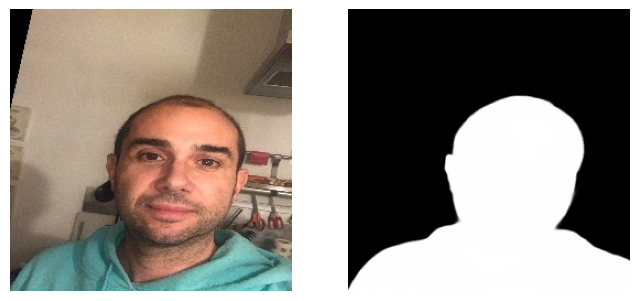

In [17]:
import matplotlib.pyplot as plt
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path,0)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.axis('off')


## Augmentation
Online Augmentation (during training)

This is the train_tfms inside the dataset class.

Purpose: randomize input every epoch so the model never sees the exact same image twice.

In [18]:
train_tfms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5)
])


val_tfms = A.Compose([A.Resize(256, 256)])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [19]:
# data set and data loaders
train_ds = SegDataset("dataset/train/images", "dataset/train/masks", transforms=train_tfms)
val_ds   = SegDataset("dataset/val/images", "dataset/val/masks", transforms=val_tfms)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")


Train samples: 339, Val samples: 85


## Define model, loss, optimizer

In [ ]:
# !git clone https://github.com/xuebinqin/U-2-Net.git

In [20]:
import torch
import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Model (UNet with ResNet34 encoder) ---
model = smp.Unet(
    encoder_name="resnet34",      # backbone
    encoder_weights="imagenet",   # use pretrained weights
    in_channels=3,                # RGB input
    classes=1,                    # binary segmentation
).to(device)

# --- Losses ---
dice_loss = smp.losses.DiceLoss(mode="binary", from_logits=True)
bce_loss = smp.losses.SoftBCEWithLogitsLoss()

def loss_fn(y_pred, y_true, alpha=0.5):
    """Hybrid loss: Dice + BCE"""
    return alpha * dice_loss(y_pred, y_true) + (1 - alpha) * bce_loss(y_pred, y_true)

# --- Optimizer ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 98.9MB/s]


In [21]:
# --- Post-processing ---
def clean_mask(mask):
    """
    Post-process segmentation mask:
    1. Ensure binary
    2. Morphological cleaning
    3. Keep largest contour (remove small blobs)
    4. Smooth edges with Gaussian blur
    """

    # Ensure mask is a numpy array and not None
    if mask is None:
        return None

    # 1. Ensure binary (0/1)
    mask = (mask > 0).astype(np.uint8)

    # 2. Morphological operations
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   # remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # fill small holes

    # 3. Keep largest contour only
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        new_mask = np.zeros_like(mask)
        cv2.drawContours(new_mask, [largest], -1, 1, thickness=cv2.FILLED)
        mask = new_mask

    # 4. Smooth edges with Gaussian blur
    mask = cv2.GaussianBlur(mask.astype(np.float32), (5, 5), 0)
    mask = (mask > 0.5).astype(np.uint8)  # re-binarize after blur

    return mask


# --- Training Loop ---
def train_epoch(loader):
    model.train()
    total_loss = 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        preds = model(imgs)      # keep only d0 (main prediction)

        loss = loss_fn(preds, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# --- Evaluation Loop ---
def eval_epoch(loader):
    model.eval()
    total_loss = 0
    iou_scores = []
    acc_scores = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            total_loss += loss.item()

            # Threshold predictions
            preds_bin = (torch.sigmoid(preds) > 0.5).float()

            # --- Post-process each mask ---
            preds_clean = []
            for mask_pred in preds_bin.cpu().numpy():
                mask_pred = mask_pred.squeeze().astype(np.uint8)
                mask_pred = clean_mask(mask_pred)
                if mask_pred is not None: # Check if clean_mask returned a mask
                    preds_clean.append(mask_pred)

            if not preds_clean: # Skip if no masks were processed
                continue

            preds_clean = torch.tensor(np.array(preds_clean)).unsqueeze(1).to(device)

            # IoU
            intersection = (preds_clean * (masks > 0.5)).float().sum((1,2,3))
            union = (preds_clean + (masks > 0.5)).float().sum((1,2,3)) - intersection
            iou = (intersection + 1e-6) / (union + 1e-6)
            iou_scores.extend(iou.cpu().numpy())

            # Pixel Accuracy
            correct = (preds_clean == (masks > 0.5)).float().sum((1,2,3))
            total = torch.numel(preds_clean[0])
            acc = correct / total
            acc_scores.extend(acc.cpu().numpy())

    return (
        total_loss / len(loader),
        np.mean(iou_scores) if iou_scores else 0, # Handle case where iou_scores is empty
        np.mean(acc_scores) if acc_scores else 0  # Handle case where acc_scores is empty
    )

# --- Run Training ---
num_epochs = 20
train_losses, val_losses, val_ious, val_accs = [], [], [], []

for epoch in range(num_epochs):
    train_loss = train_epoch(train_loader)
    val_loss, val_iou, val_acc = eval_epoch(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val IoU: {val_iou:.4f} | "
          f"Val Acc: {val_acc:.4f}")

Epoch 1/20 | Train Loss: 0.3795 | Val Loss: 0.2440 | Val IoU: 0.7763 | Val Acc: 0.9199
Epoch 2/20 | Train Loss: 0.2219 | Val Loss: 0.1808 | Val IoU: 0.8164 | Val Acc: 0.9450
Epoch 3/20 | Train Loss: 0.1704 | Val Loss: 0.1359 | Val IoU: 0.8488 | Val Acc: 0.9603
Epoch 4/20 | Train Loss: 0.1385 | Val Loss: 0.1262 | Val IoU: 0.8631 | Val Acc: 0.9602
Epoch 5/20 | Train Loss: 0.1260 | Val Loss: 0.1016 | Val IoU: 0.8859 | Val Acc: 0.9706
Epoch 6/20 | Train Loss: 0.1018 | Val Loss: 0.0916 | Val IoU: 0.8979 | Val Acc: 0.9728
Epoch 7/20 | Train Loss: 0.1087 | Val Loss: 0.0936 | Val IoU: 0.8767 | Val Acc: 0.9685
Epoch 8/20 | Train Loss: 0.1057 | Val Loss: 0.0866 | Val IoU: 0.9009 | Val Acc: 0.9735
Epoch 9/20 | Train Loss: 0.0856 | Val Loss: 0.0732 | Val IoU: 0.9206 | Val Acc: 0.9790
Epoch 10/20 | Train Loss: 0.0726 | Val Loss: 0.0690 | Val IoU: 0.9258 | Val Acc: 0.9806
Epoch 11/20 | Train Loss: 0.0718 | Val Loss: 0.0851 | Val IoU: 0.9124 | Val Acc: 0.9728
Epoch 12/20 | Train Loss: 0.0725 | Val Lo

* The F1 score and the Dice coefficient are mathematically equivalent in the binary / two-class case
* F1 Score → used in classification metrics (e.g., text classification, binary classification).

* Dice Coefficient → used in image segmentation and medical imaging (overlap measure).

In [22]:
# save model
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/unet_resnet34.pth")
print("Model saved!")


Model saved!


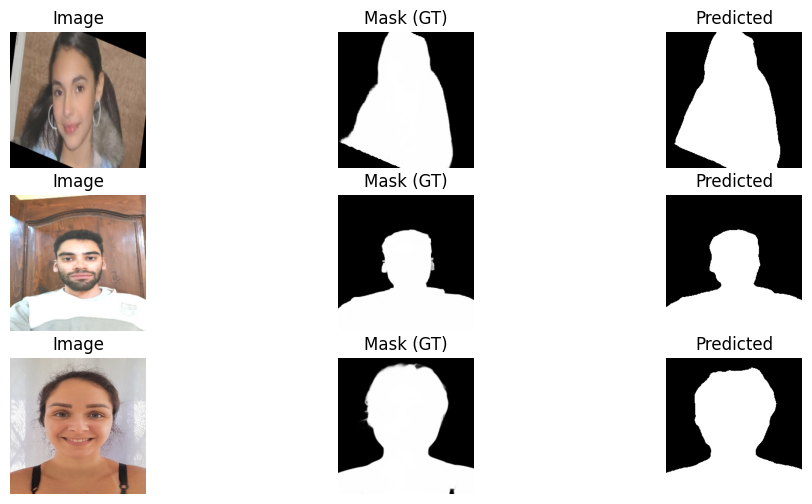

In [23]:
# visualize predictions
model.eval()
imgs, masks = next(iter(val_loader))
imgs, masks = imgs.to(device), masks.to(device)
with torch.no_grad():
    preds = torch.sigmoid(model(imgs)) > 0.5

plt.figure(figsize=(12,6))
for i in range(3):
    plt.subplot(3,3,3*i+1)
    plt.imshow(np.transpose(imgs[i].cpu().numpy(), (1,2,0)))
    plt.axis("off")
    plt.title("Image")

    plt.subplot(3,3,3*i+2)
    plt.imshow(masks[i].cpu().numpy().squeeze(), cmap="gray")
    plt.axis("off")
    plt.title("Mask (GT)")

    plt.subplot(3,3,3*i+3)
    plt.imshow(preds[i].cpu().numpy().squeeze(), cmap="gray")
    plt.axis("off")
    plt.title("Predicted")
plt.show()


### Metrics: How to Calculate IoU & Pixel Accuracy

In [24]:
import torch

def evaluate_metrics(pred, gt):
    """
    pred, gt: tensors (H, W) with values {0,1}
    """
    pred = pred.bool()
    gt = gt.bool()

    intersection = (pred & gt).sum().item()
    union = (pred | gt).sum().item()
    correct = (pred == gt).sum().item()
    total = pred.numel()

    iou = intersection / union if union > 0 else 1.0
    acc = correct / total
    return iou, acc

# Example loop
ious, accs = [], []
for img, gt_mask in val_loader:
    with torch.no_grad():
        pred_mask = torch.sigmoid(model(img.to(device))) > 0.5
    for p, g in zip(pred_mask.cpu(), gt_mask):
        iou, acc = evaluate_metrics(p.squeeze(), g.squeeze())
        ious.append(iou); accs.append(acc)

print("Mean IoU:", sum(ious)/len(ious))
print("Mean Accuracy:", sum(accs)/len(accs))


Mean IoU: 0.8800103001418907
Mean Accuracy: 0.9499369901769301
